# Plot three-panel plot of cloud base/cloud top height distribution from w-band, SEA-POL echo top height distribution, and spatial map of echo top height

- cloud base/cloud top height from cloudnet product
- echo top height from SEA-POL volume level 4b

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import cftime
import json
import glob
import os

import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import seaborn as sns

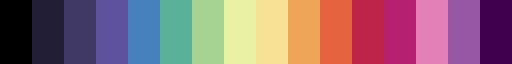

In [2]:
# Load colormap

# Read the colormap from a .txt file
def load_colormap_from_txt(file_path):
    # Load RGB values from the file
    rgb_values = np.loadtxt(file_path)
    return ListedColormap(rgb_values)

# Example usage
colormap_file = 'chase-spectral-rgb.txt'  # Replace with your .txt file path
radar_cmap = load_colormap_from_txt(colormap_file)

discrete_cmap = ListedColormap(radar_cmap(np.linspace(0, 1, 16)))
discrete_mask_cmap = discrete_cmap.copy()
discrete_mask_cmap.set_under(color='white') #set values below vmin to white
discrete_mask_cmap.set_bad(color='lightgray') #set missing (NaN) values to gray

discrete_mask_cmap2 = discrete_mask_cmap.copy()
discrete_mask_cmap2.set_under(color='black') #set values below vmin to black
discrete_mask_cmap2.set_bad(color='white') #set missing (NaN) values to white

discrete_mask_cmap

W-band cloud radar

In [3]:
# Read in data
#QmSw6jc9FrcY6tcnKw2bvHJ2NYwS5WwRjSsPxNM4fcVvTr
#wband = xr.open_dataset("ipfs://bafybeiceihwds4qy6nqxfpp7qqot7xjlpjrtv5yq3t6uwnupk3bawhnbte", engine="zarr")
wband = xr.open_dataset("ipns://latest.orcestra-campaign.org/products/METEOR/cloudnet.zarr", engine="zarr")
wband

<xarray.Dataset> Size: 7GB
Dimensions:                 (time: 106200, height: 393)
Coordinates:
  * height                  (height) float32 2kB 120.3 135.3 ... 1.198e+04
  * time                    (time) datetime64[ns] 850kB 2024-08-17T00:00:15 ....
Data variables: (12/55)
    N_scaled                (time, height) float32 167MB ...
    Tw                      (time, height) float32 167MB ...
    Z                       (time, height) float32 167MB ...
    Z_bias                  (time) float32 425kB ...
    Z_error                 (time, height) float32 167MB ...
    Z_sensitivity           (time, height) float32 167MB ...
    ...                      ...
    rain_detected           (time) float64 850kB ...
    rainfall_rate           (time) float32 425kB ...
    target_classification   (time, height) float64 334MB ...
    v                       (time, height) float32 167MB ...
    v_sigma                 (time, height) float32 167MB ...
    width                   (time, height) float32 167MB ...
Attributes: (12/18)
    Conventions:         CF-1.8
    cloudnet_file_type:  der
    title:               Cloudnet droplet effective radius on RV Meteor durin...
    location:            RV Meteor
    year:                2024
    source:              RPG-Radiometer Physics RPG-FMCW-94\nLufft CHM15k\nEC...
    ...                  ...
    platform:            RV METEOR
    institution:         Leipzig Institute for Meteorology, Leipzig University
    instrument:          Cloudnet product based on cloud radar, ceilometer, m...
    creator_id:          ORCiD: 0000-0002-1164-3576
    keywords:            Cloudnet, effective radius, droplet
    featureType:         trajectoryProfile

SEA-POL data

In [ ]:
# read in data
seapol = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4v1.1/PICCOLO_level4_volume_3D.nc')
seapol

<xarray.Dataset> Size: 410GB
Dimensions:       (time: 8371, Z: 19, Y: 241, X: 241)
Coordinates:
  * X             (X) float32 964B -1.2e+05 -1.19e+05 ... 1.19e+05 1.2e+05
  * Y             (Y) float32 964B -1.2e+05 -1.19e+05 ... 1.19e+05 1.2e+05
  * Z             (Z) float32 76B 0.0 1e+03 2e+03 ... 1.6e+04 1.7e+04 1.8e+04
    latitude      (time, Y, X) float32 2GB ...
    longitude     (time, Y, X) float32 2GB ...
  * time          (time) datetime64[ns] 67kB 2024-08-16T08:10:00 ... 2024-09-...
Data variables: (12/15)
    HID_CSU       (time, Z, Y, X) float32 37GB ...
    DBZ           (time, Z, Y, X) float32 37GB ...
    KDP           (time, Z, Y, X) float32 37GB ...
    PHIDP         (time, Z, Y, X) float32 37GB ...
    RAINRATE      (time, Z, Y, X) float32 37GB ...
    RHOHV         (time, Z, Y, X) float32 37GB ...
    ...            ...
    WIDTH         (time, Z, Y, X) float32 37GB ...
    ZDR           (time, Z, Y, X) float32 37GB ...
    grid_mapping  int32 4B ...
    heading       (time) float32 33kB ...
    start_time    (time) datetime64[ns] 67kB ...
    stop_time     (time) datetime64[ns] 67kB ...
Attributes: (12/15)
    Conventions:       CF-1.12
    institution:       Colorado State University
    source:            CSU SEA-POL radar
    instrument:        SEA-POL
    title:             Level 4 Gridded SEA-POL Radar Data
    summary:           Level 4 Gridded SEA-POL Radar Data
    ...                ...
    project:           PICCOLO, BOWTIE, ORCESTRA
    platform:          RV METEOR
    keywords:          radar, precipitation, sea-pol
    processing_level:  Level 4
    license:           CC-BY-4.0
    history:           v1.0 using bsharp gridding

In [5]:
# sea-pol echo top height data
seapol_echotop = xr.open_dataset('../../../data/SEA-POLv1.0_echo_top_height_vol1_50_120.nc') #VOL1, 50-120 km
seapol_echotop

<xarray.Dataset> Size: 283MB
Dimensions:          (data points: 17665648)
Coordinates:
  * data points      (data points) int64 141MB 0 1 2 ... 17665646 17665647
Data variables:
    echo_top_height  (data points) float64 141MB ...

Calculate percentages of echo top height

In [6]:
#Calculate percentage of echo top heights greater than 12 km
n_echo_12km = np.size(np.where(seapol_echotop.echo_top_height.values>12000))/(np.size(seapol_echotop.echo_top_height.values))
print('Percent of echo tops > 12 km:', n_echo_12km)

#Calculate percentage of echo top heights greater than 8 km (deep convection)
n_echo_deep = np.size(np.where(seapol_echotop.echo_top_height.values>8000))/(np.size(seapol_echotop.echo_top_height.values))
print('Percent of echo tops > 8 km:', n_echo_deep)

#Calculate percentage of echo top heights less than 3 km (shallow convection)
n_echo_shallow = np.size(np.where(seapol_echotop.echo_top_height.values<3000))/(np.size(seapol_echotop.echo_top_height.values))
print('Percent of echo tops < 3 km:', n_echo_shallow)

#Calculate percentage of echo top heights between 3-8 km (congestus)
n_echo_congestus = np.size(np.where((seapol_echotop.echo_top_height.values>3000) & (seapol_echotop.echo_top_height.values<8000)))/(np.size(seapol_echotop.echo_top_height.values))
print('Percent of echo tops > 3 km and < 8 km:', n_echo_congestus)

Percent of echo tops > 12 km: 0.01526923892064418
Percent of echo tops > 8 km: 0.17640269974812134
Percent of echo tops < 3 km: 0.07691152908741304
Percent of echo tops > 3 km and < 8 km: 0.5389857196294187


Calculate SEA-POL echo top height for one single time to plot as a map

In [7]:
#Define time period for spatial map
#time_map = np.datetime64('2024-09-08T15:50')
time_map = np.datetime64('2024-09-01T07:50')
#time_map = np.datetime64('2024-09-02T04:20')

index_map = np.abs(pd.to_datetime(seapol.time) - time_map).argmin()
map_dbz = seapol.DBZ[index_map,:,:,:]

# set to nan outside of radius 120 km to only include data with the 3D volume
radius = 120  # km
distances = np.sqrt((map_dbz.latitude - map_dbz.latitude[120, 120])**2 + (map_dbz.longitude - map_dbz.longitude[120, 120])**2) * 111.32  # Approximate conversion from degrees to km
map_dbz = map_dbz.where(distances<=radius,np.nan)  # Set values outside the radius to NaN


In [8]:
#find the maximum height where the reflectivity is above a threshold
threshold = 10

# mask for valid (non-NaN) data
valid_data = ~np.isnan(map_dbz.values)

# mask for reflectivity above threshold
above_thresh = valid_data & (map_dbz.values >= threshold)

# Find the highest index (height) where above_thresh is True for each (y, x), if not found return -1
max_indices = np.where(above_thresh.any(axis=0), above_thresh.shape[0] - 1 - np.argmax(above_thresh[::-1], axis=0), -1)

# Initialize output: NaN where no valid data, -5 where threshold not met
echo_top_height = np.full(map_dbz.shape[1:], np.nan)
has_valid = valid_data.any(axis=0)
echo_top_height[has_valid] = -5

# Set echo top height where threshold is met
valid = max_indices != -1
echo_top_height[valid] = map_dbz.Z.values[max_indices[valid].astype(int)]

Apply rain attenuation flag to w-band data

In [9]:
#exclude data where rain attenuation flag equals 1
wband_cloudbase = wband.cloud_base_height_amsl[wband.rain_attenuation_flag!=1]
wband_cloudtop = wband.cloud_top_height_amsl[wband.rain_attenuation_flag!=1]

## OR ##

#use all data
#wband_cloudbase = wband.cloub_base_height_amsl
#wband_cloudtop = wband.cloud_top_height_amsl

Plot 

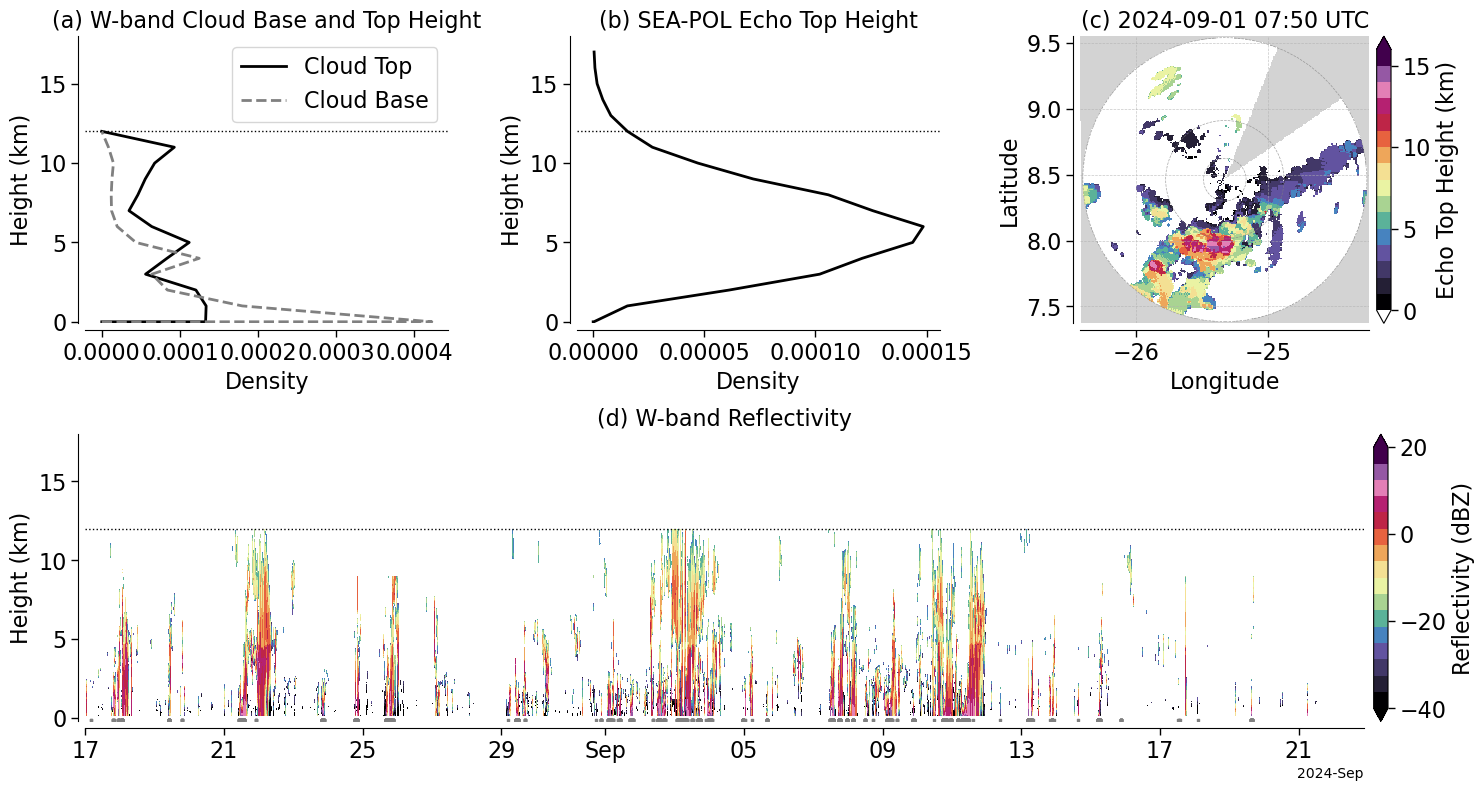

In [10]:
#Plot pdf of wband cloud base and top height
fig, axs = plt.subplots(2,3,figsize=(15,8))

# Hide unused axes in the second row
axs[1, 1].set_visible(False)
axs[1, 2].set_visible(False)

# Remove axs[1, 0] and replace it with a new axis that spans all columns in the second row
gs = fig.add_gridspec(2, 3)
ax_big = fig.add_subplot(gs[1, :]) 

# Remove the original axes in the second row
for ax in [axs[1, 0], axs[1, 1], axs[1, 2]]:
    fig.delaxes(ax)

bins =np.concatenate(([-1],np.arange(0, 14000, 1000)))
seapol_bins = np.concatenate(([-1],np.arange(0, 18500, 1000)))
cb_hist, bin_edges_cb = np.histogram(wband_cloudbase, bins=bins, density=True)
ct_hist, bin_edges_ct = np.histogram(wband_cloudtop, bins=bins, density=True)
eth_hist, bin_edges_eth = np.histogram(seapol_echotop.echo_top_height, bins=seapol_bins, density=True)


axs[0,0].plot(ct_hist,bin_edges_ct[:-1]/1000,color='black', linewidth=2,label='Cloud Top')
axs[0,0].plot(cb_hist,bin_edges_cb[:-1]/1000,color='gray', linestyle = '--', linewidth=2,label='Cloud Base')

#add a horizontal line at 12000
axs[0,0].axhline(12, color='black', linestyle=':', linewidth=1)

axs[0,0].set_xlabel('Density',fontsize=16)
axs[0,0].set_ylabel('Height (km)',fontsize=16)
axs[0,0].set_ylim([-.1,18])
axs[0,0].tick_params(axis='both', labelsize=16)
axs[0,0].legend(fontsize=16)
axs[0,0].set_title('(a) W-band Cloud Base and Top Height', fontsize=16)

axs[0,1].plot(eth_hist,bin_edges_eth[:-1]/1000,color='black', linewidth=2,label='Echo Top')

# add a horizontal line at 12 km
axs[0,1].axhline(12, color='black', linestyle=':', linewidth=1)

axs[0,1].set_xlabel('Density',fontsize=16)
axs[0,1].set_ylabel('Height (km)',fontsize=16)
axs[0,1].set_ylim([-.1,18])
axs[0,1].tick_params(axis='both', labelsize=16)
#axs[0,1].legend(fontsize=16)
axs[0,1].set_title('(b) SEA-POL Echo Top Height', fontsize=16)

cax = axs[0,2].pcolormesh(map_dbz.longitude, map_dbz.latitude, echo_top_height/1000, cmap=discrete_mask_cmap, vmin=0, vmax=16)
axs[0,2].set_aspect('equal',adjustable='box')
cbar = fig.colorbar(cax, ax=axs[0,2], extend='both',orientation='vertical',pad=0.02)
cbar.ax.tick_params(labelsize=16)
#cbar.set_ticks(np.linspace(-10,60,8))
cbar.ax.set_ylabel('Echo Top Height (km)', fontsize=16)

dt_str = pd.to_datetime(seapol.time[index_map].values).strftime('%Y-%m-%d %H:%M')
axs[0,2].set_title('(c) ' + dt_str + ' UTC',fontsize=16)
axs[0,2].tick_params(axis='both', labelsize=16)
axs[0,2].set_xlabel('Longitude', fontsize=16)
axs[0,2].set_ylabel('Latitude', fontsize=16)


# Add grid lines 
axs[0,2].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Add 120 km circle
axs[0,2].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 120/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
# Add 50 km circle
axs[0,2].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 50/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
# Add 18 km circle
axs[0,2].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 18/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))

# Add w-band reflectivity
ax_big.clear()
#cax = ax_big.pcolormesh(mdates.date2num(wband.time.values), wband.height/1000, wband.Z.transpose(), cmap=discrete_mask_cmap, vmin=-40, vmax=20)
plot_wband = wband.assign_coords({'height':wband.height.values/1000}).Z.plot(
    x='time',cmap=discrete_mask_cmap2, vmin=-40,vmax=20,shading='auto',add_colorbar=False,add_labels=False)

# add a horizontal line at 12 km
ax_big.axhline(12, color='black', linestyle=':', linewidth=1)

# Add dots for rain attenuation flag == 1
rain_flag_mask = (wband.rain_attenuation_flag.transpose() == 1)
#make array of zeros length of rain_flag_mask
zeros_array = np.zeros(rain_flag_mask.shape)-0.1
ax_big.scatter(wband.time.values[rain_flag_mask],zeros_array[rain_flag_mask],color='gray', s=1, marker='s')

cbar2 = fig.colorbar(plot_wband, ax=ax_big, extend='both',orientation='vertical',pad=-0.1,location='right', anchor=(0.77, 0.5))
cbar2.ax.tick_params(labelsize=16) 
cbar2.ax.set_ylabel('Reflectivity (dBZ)', fontsize=16)

ax_big.set_ylabel('Height (km)', fontsize=16)
ax_big.tick_params(axis='both', labelsize=16)
ax_big.set_ylim([-0.2,18])
ax_big.set_title('(d) W-band Reflectivity', fontsize=16)

sns.set_context('paper') 
sns.despine(offset=5)
sns.despine(ax=cbar.ax, left=True, bottom=True, right=True, top=True)
sns.despine(ax=cbar2.ax, left=True, bottom=True, right=True, top=True)
plt.tight_layout() 

plt.savefig('../Plots/Fig_echo_base_top.png', bbox_inches='tight', dpi=300)